# kNN • Naive Bayes • k-Fold Cross-Validation (Langkah Demi Langkah)

**Isi:**
1) kNN — teori singkat → **hitung manual** → praktik di Iris (pipeline + evaluasi)
2) k-Fold CV — konsep → praktik (kNN)
3) Naive Bayes — teori → **hitung manual teks** → MultinomialNB (20 Newsgroups) → GaussianNB (Iris)
4) **Data Leakage** — contoh **salah vs benar** (pipeline)

## 1) kNN — Intuisi & Rumus Jarak
- k-Nearest Neighbors (kNN) **mengingat data latih**.
- Prediksi titik baru: hitung **jarak** → ambil **k tetangga** → **voting** kelas.
- Parameter penting: `k` (3/5/7), **jarak** (Euclidean), dan **scaling** fitur numerik.

### 1A) Hitung Manual kNN (k=3)
Data latih (2D, kelas 0/1):

| Titik | x | y | Kelas |
|---|---:|---:|---:|
| A | 1 | 1 | 0 |
| B | 2 | 2 | 0 |
| C | 1 | 2 | 0 |
| D | 5 | 5 | 1 |
| E | 6 | 5 | 1 |
| F | 5 | 6 | 1 |

Titik uji **T=(3,3)**. Kita hitung jarak ke semua titik, urutkan, ambil 3 terdekat.

In [1]:
import math
train = {
    'A': (1,1,0), 'B': (2,2,0), 'C': (1,2,0),
    'D': (5,5,1), 'E': (6,5,1), 'F': (5,6,1)
}
T = (3,3)
def dist(p,q):
    return math.sqrt((p[0]-q[0])**2 + (p[1]-q[1])**2)

dlist = []
for name,(x,y,lab) in train.items():
    d = dist((x,y), T)
    dlist.append((name, d, lab))

dlist_sorted = sorted(dlist, key=lambda x: x[1])
dlist_sorted

[('B', 1.4142135623730951, 0),
 ('C', 2.23606797749979, 0),
 ('A', 2.8284271247461903, 0),
 ('D', 2.8284271247461903, 1),
 ('E', 3.605551275463989, 1),
 ('F', 3.605551275463989, 1)]

**Cara membaca output:** ambil 3 teratas (k=3) → voting mayoritas kelas → prediksi.

## 2) kNN pada Dataset Publik: Iris (Tabular)
Kita akan: muat data → EDA singkat → split → **pipeline (scaling + kNN)** → evaluasi.

In [2]:
import numpy as np, pandas as pd
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)
df = iris.frame.copy()
df.columns = ['sepal_length','sepal_width','petal_length','petal_width','label']
df.head()

,sepal_length,sepal_width,petal_length,petal_width,label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
print('Bentuk data:', df.shape)
print('\nTipe kolom:')
print(df.dtypes)
print('\nProporsi label:')
print(df['label'].value_counts(normalize=True).round(3))

Bentuk data: (150, 5)

Tipe kolom:
sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
label             int64
dtype: object

Proporsi label:
label
0    0.333
1    0.333
2    0.333
Name: proportion, dtype: float64


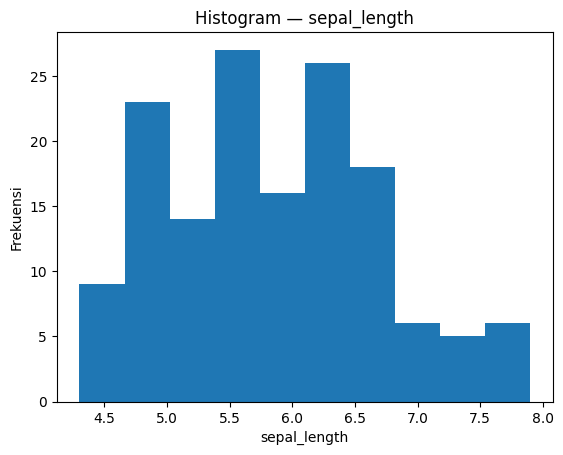

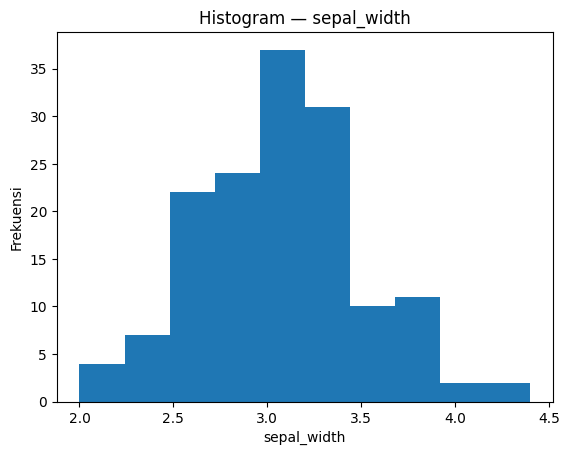

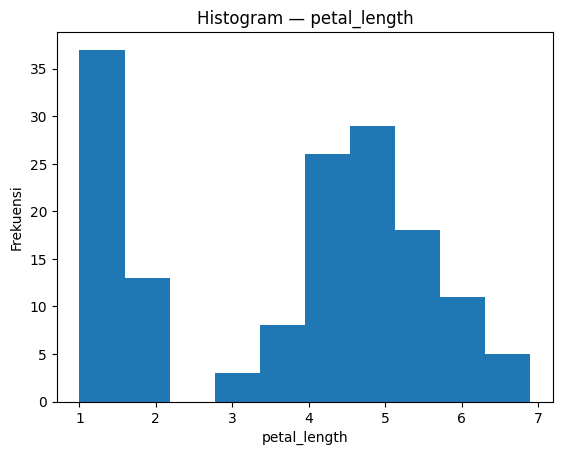

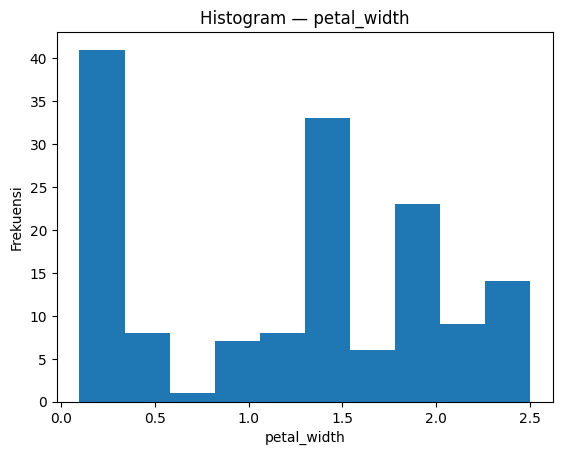

In [4]:
import matplotlib.pyplot as plt
for col in ['sepal_length','sepal_width','petal_length','petal_width']:
    fig = plt.figure()
    plt.hist(df[col])
    plt.title(f'Histogram — {col}')
    plt.xlabel(col); plt.ylabel('Frekuensi')
    plt.show()

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.83      1.00      0.91        10
   virginica       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



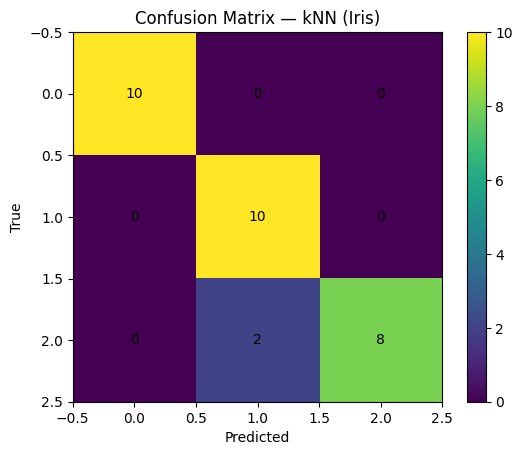

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

X = df[['sepal_length','sepal_width','petal_length','petal_width']].values
y = df['label'].values
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

knn_clf = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))
knn_clf.fit(X_tr, y_tr)
y_pr = knn_clf.predict(X_te)
print(classification_report(y_te, y_pr, target_names=iris.target_names))

cm = confusion_matrix(y_te, y_pr)
fig = plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix — kNN (Iris)')
plt.xlabel('Predicted'); plt.ylabel('True')
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.colorbar(); plt.show()

## 3) k-Fold Cross-Validation (StratifiedKFold)
**Ide:** bagi data jadi `k` bagian → latih/validasi `k` kali → rata-rata skor.
Lebih stabil daripada satu split. Untuk klasifikasi, pakai **StratifiedKFold**.

In [6]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5)),
                         X, y, cv=cv, scoring='accuracy')
print('Fold scores:', scores)
print('Mean ± std:', scores.mean().round(3), '±', scores.std().round(3))

Fold scores: [1.         0.96666667 0.93333333 1.         0.96666667]
Mean ± std: 0.973 ± 0.025


## 4) Naive Bayes — Intuisi & Hitung Manual (Teks Mini)
- Bayes: \(P(y|X) \propto P(X|y)P(y)\); "Naive": anggap kata independen bersyarat.
- Korpus mini: 3 Spam (ada kata *gratis*), 3 Ham (ada kata *besok*). Uji: "gratis hadiah".

In [7]:
from collections import Counter
spam_docs = ["gratis hadiah", "gratis kupon", "hadiah besar gratis"]
ham_docs  = ["rapat besok", "tugas besok dikumpulkan", "jadwal kuliah besok"]
def tok(s): return s.split()
spam_tokens = [w for d in spam_docs for w in tok(d)]
ham_tokens  = [w for d in ham_docs  for w in tok(d)]
V = set(spam_tokens) | set(ham_tokens); V_size = len(V)
alpha = 1.0
cs, ch = Counter(spam_tokens), Counter(ham_tokens)
Ts, Th = sum(cs.values()), sum(ch.values())
P_s = len(spam_docs)/(len(spam_docs)+len(ham_docs)); P_h = 1-P_s
def PwS(w): return (cs.get(w,0)+alpha)/(Ts+alpha*V_size)
def PwH(w): return (ch.get(w,0)+alpha)/(Th+alpha*V_size)
test = "gratis hadiah".split()
ss, sh = P_s, P_h
for w in test:
    ss *= PwS(w); sh *= PwH(w)
ss, sh, ('Spam' if ss>sh else 'Ham')

(0.020761245674740487, 0.0015432098765432098, 'Spam')

## 5) Multinomial NB — 20 Newsgroups (Subset)
Langkah: muat 3 kategori → split → `CountVectorizer` → `MultinomialNB` → evaluasi.

In [8]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

cats = ['sci.med','rec.sport.baseball','talk.politics.misc']
ds = fetch_20newsgroups(subset='all', categories=cats, remove=('headers','footers','quotes'))
Xtr, Xte, ytr, yte = train_test_split(ds.data, ds.target, test_size=0.2, random_state=42, stratify=ds.target)
nb_pipe = Pipeline([
    ('vec', CountVectorizer(min_df=3, ngram_range=(1,2))),
    ('nb', MultinomialNB())
])
nb_pipe.fit(Xtr, ytr)
print(classification_report(yte, nb_pipe.predict(Xte), target_names=cats))

                    precision    recall  f1-score   support

           sci.med       0.92      0.90      0.91       199
rec.sport.baseball       0.92      0.93      0.92       198
talk.politics.misc       0.89      0.90      0.89       155

          accuracy                           0.91       552
         macro avg       0.91      0.91      0.91       552
      weighted avg       0.91      0.91      0.91       552



## 6) Gaussian NB — Iris (Numerik)
GaussianNB mengasumsikan fitur numerik tiap kelas ~ normal.

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
X = df[['sepal_length','sepal_width','petal_length','petal_width']].values
y = df['label'].values
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
gnb = GaussianNB().fit(Xtr, ytr)
print('Accuracy:', accuracy_score(yte, gnb.predict(Xte)))

Accuracy: 0.9666666666666667


## 7) Data Leakage — SALAH vs BENAR (Pipeline)
- **Salah**: scaling sebelum split (info test bocor)
- **Benar**: split → scaling dalam **Pipeline** (fit di train saja)

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

toy = pd.DataFrame({'x_num':[1,2,3,4,5,6,7,8], 'y':[0,0,0,1,0,1,0,1]})
from sklearn.model_selection import train_test_split

# Salah
sc_all = StandardScaler(); toy['x_scaled_wrong'] = sc_all.fit_transform(toy[['x_num']])
Xw = toy[['x_scaled_wrong']].values; yw = toy['y'].values
Xw_tr, Xw_te, yw_tr, yw_te = train_test_split(Xw, yw, test_size=0.25, random_state=42, stratify=yw)
score_wrong = LogisticRegression(max_iter=1000).fit(Xw_tr, yw_tr).score(Xw_te, yw_te)

# Benar
Xb = toy[['x_num']].values; yb = toy['y'].values
Xb_tr, Xb_te, yb_tr, yb_te = train_test_split(Xb, yb, test_size=0.25, random_state=42, stratify=yb)
pipe = Pipeline([('sc', StandardScaler()), ('lr', LogisticRegression(max_iter=1000))])
score_right = pipe.fit(Xb_tr, yb_tr).score(Xb_te, yb_te)

print({'score_salah(leakage)': score_wrong, 'score_benar(pipeline)': score_right})

{'score_salah(leakage)': 0.5, 'score_benar(pipeline)': 0.5}
